## Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler


from Code.plot_data import *
from Code.preprocessing import *
from Code.wgan_gp import *
from Code.test_pred import *

In [2]:
data = pd.read_csv(r'Data\DataFacebook.csv', parse_dates=['date'])

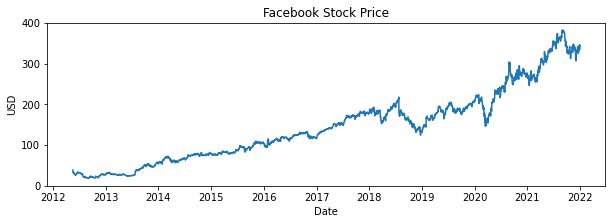

In [3]:
plotFacebookStock(data)

In [4]:
# Get technical features
technical_data = get_technical_indicators(data)
technical_data = technical_data.iloc[20:,:].reset_index(drop=True)

# Get Fourier features
fourier_data = get_fourier_transfer(technical_data)

# Get all features
data_final = pd.concat([technical_data, fourier_data], axis=1)

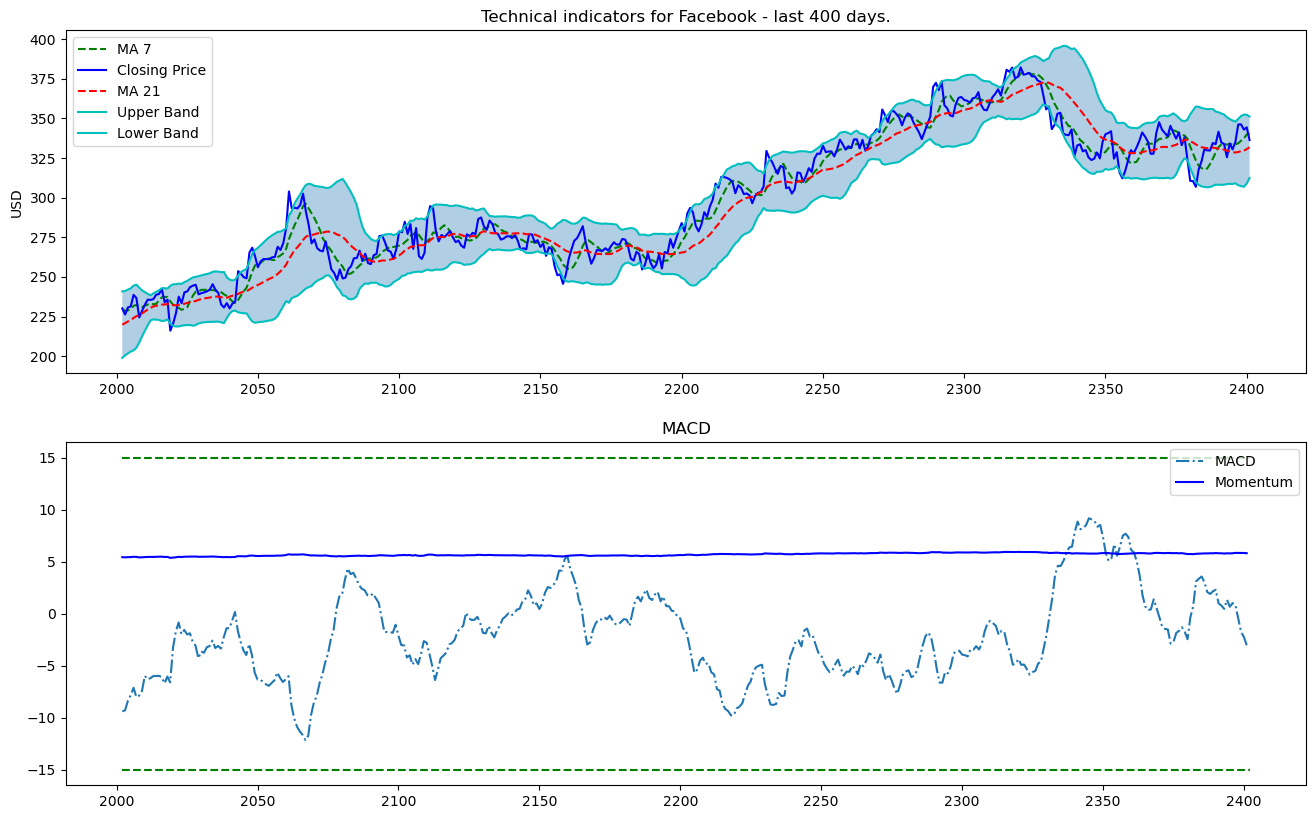

In [5]:
plot_technical_indicators(technical_data, 400)

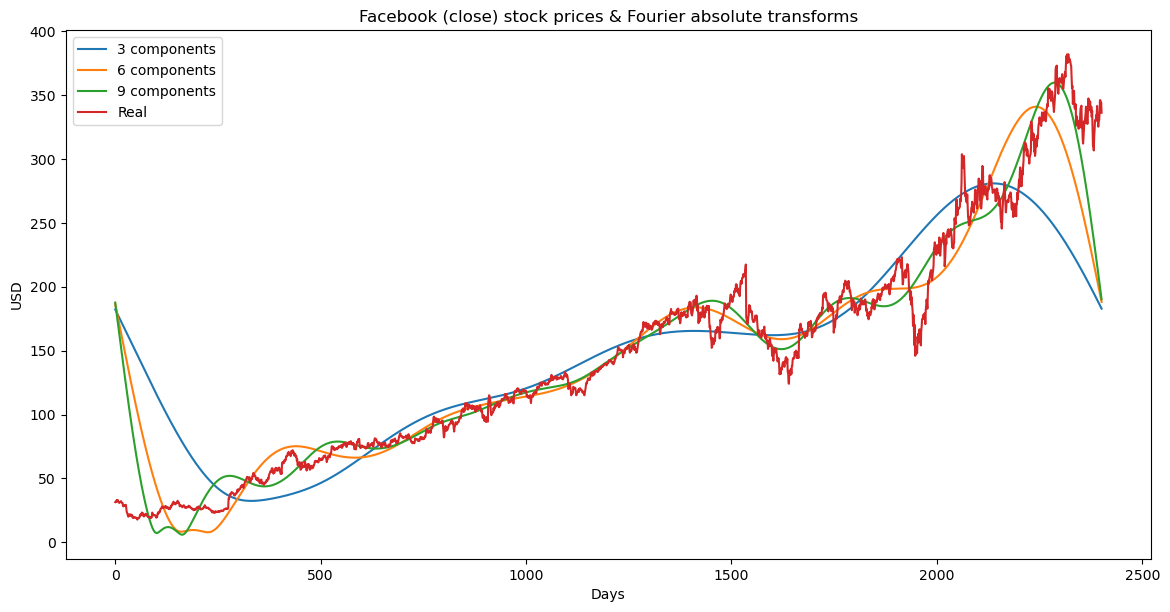

In [6]:
plot_Fourier(data_final)

In [7]:
manage_nan(data_final)
data_final = manage_dates(data_final)

In [8]:
# Get features and target
X = pd.DataFrame(data_final.iloc[:, :])
y = pd.DataFrame(data_final.iloc[:, 0])

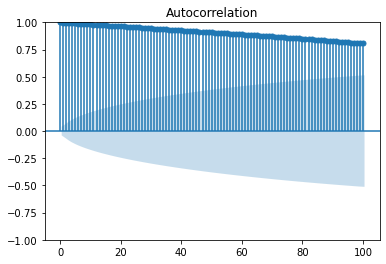

In [9]:
# Autocorrelation Check
sm.graphics.tsa.plot_acf(y.squeeze(), lags=100)
plt.show()

In [10]:
# Normalized the data
X_scaler_function = MinMaxScaler(feature_range=(-1, 1))
y_scaler_function = MinMaxScaler(feature_range=(-1, 1))

X_scaled = X_scaler_function.fit_transform(X)
y_scaled = y_scaler_function.fit_transform(y)

In [11]:
N_STEPS_IN = 3
N_STEPS_OUT = 1
pathToSave = r'Data\dataPreprocessed'
reshape_dataset(pathToSave, data_final, X_scaled, y_scaled, N_STEPS_IN, N_STEPS_OUT)

X shape:  (2399, 3, 36)
y shape:  (2399, 1)
X_train shape:  (1679, 3, 36)
y_train shape:  (1679, 1)
y_c_train shape:  (1679, 3, 1)
X_test shape:  (720, 3, 36)
y_test shape:  (720, 1)
y_c_test shape:  (720, 3, 1)
index_train shape: (1679,)
index_test shape: (720,)
Everything saved in  Data\dataPreprocessed


## Training

In [12]:
# Load data
path = r'Data\dataPreprocessed'
X_train = np.load(os.path.join(path, "X_train.npy"), allow_pickle=True)
y_train = np.load(os.path.join(path, "y_train.npy"), allow_pickle=True)
X_test = np.load(os.path.join(path, "X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path, "y_test.npy"), allow_pickle=True)
yc_train = np.load(os.path.join(path, "yc_train.npy"), allow_pickle=True)
yc_test = np.load(os.path.join(path, "yc_test.npy"), allow_pickle=True)

In [13]:
# Hyperparameter
EPOCHS = 100
BATCH_SIZE = 128
D_STEPS = 1
G_STEPS = 3
GP_WEIGHT = 10
D_LEARNING_RATE = 0.0001
G_LEARNING_RATE = 0.0001

In [14]:
input_generator_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_generator_dim = y_train.shape[1]

# Instantiate the optimizer for both networks
discriminator_optimizer = tf.keras.optimizers.Adam(D_LEARNING_RATE)
generator_optimizer = tf.keras.optimizers.Adam(G_LEARNING_RATE)

generator = Generator(input_generator_dim, output_generator_dim, feature_size)
generator.compile()
discriminator = Discriminator()
wgan_gp = WGAN_GP(generator, discriminator, D_STEPS, G_STEPS, GP_WEIGHT)

# Compile the WGAN model.
wgan_gp.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss
)

data = X_train, y_train, yc_train
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, yc_train))
dataset = dataset.batch(BATCH_SIZE)

# Callback to save model
save_path = r'Models\trying'
EPOCH_MODEL_SAVE = 20
callback = [SaveModel(save_path, EPOCH_MODEL_SAVE)]

history = wgan_gp.fit(dataset, epochs=EPOCHS, callbacks=callback)

Epoch 1/100
14/14 [==============================] - 19s 104ms/step - d_loss: 9.6631 - g_loss: -0.0040
Epoch 2/100
14/14 [==============================] - 1s 103ms/step - d_loss: 9.0924 - g_loss: -0.0102
Epoch 3/100
14/14 [==============================] - 1s 104ms/step - d_loss: 8.3674 - g_loss: -0.0251
Epoch 4/100
14/14 [==============================] - 1s 104ms/step - d_loss: 7.4503 - g_loss: -0.0531
Epoch 5/100
14/14 [==============================] - 1s 104ms/step - d_loss: 6.3695 - g_loss: -0.0970
Epoch 6/100
14/14 [==============================] - 1s 104ms/step - d_loss: 4.8016 - g_loss: -0.1749
Epoch 7/100
14/14 [==============================] - 1s 107ms/step - d_loss: 3.0941 - g_loss: -0.3054
Epoch 8/100
14/14 [==============================] - 2s 107ms/step - d_loss: 1.1505 - g_loss: -0.5158
Epoch 9/100
14/14 [==============================] - 2s 108ms/step - d_loss: 0.1655 - g_loss: -0.7884
Epoch 10/100
14/14 [==============================] - 2s 109ms/step - d_loss: 0.1

14/14 [==============================] - 2s 121ms/step - d_loss: 0.0034 - g_loss: -0.7922
Epoch 81/100
14/14 [==============================] - 2s 123ms/step - d_loss: 0.0032 - g_loss: -0.7845
Epoch 82/100
14/14 [==============================] - 2s 123ms/step - d_loss: 0.0038 - g_loss: -0.7976
Epoch 83/100
14/14 [==============================] - 2s 127ms/step - d_loss: 0.0024 - g_loss: -0.7882
Epoch 84/100
14/14 [==============================] - 2s 123ms/step - d_loss: 0.0032 - g_loss: -0.7901
Epoch 85/100
14/14 [==============================] - 2s 124ms/step - d_loss: 0.0038 - g_loss: -0.7955
Epoch 86/100
14/14 [==============================] - 2s 122ms/step - d_loss: 0.0029 - g_loss: -0.7846
Epoch 87/100
14/14 [==============================] - 2s 123ms/step - d_loss: 0.0026 - g_loss: -0.7917
Epoch 88/100
14/14 [==============================] - 2s 127ms/step - d_loss: 0.0027 - g_loss: -0.7930
Epoch 89/100
14/14 [==============================] - 2s 126ms/step - d_loss: 0.0026 -

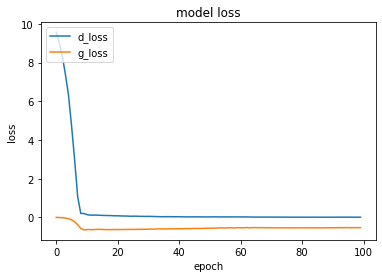

In [15]:
plot_loss(history)

## Pred Test data

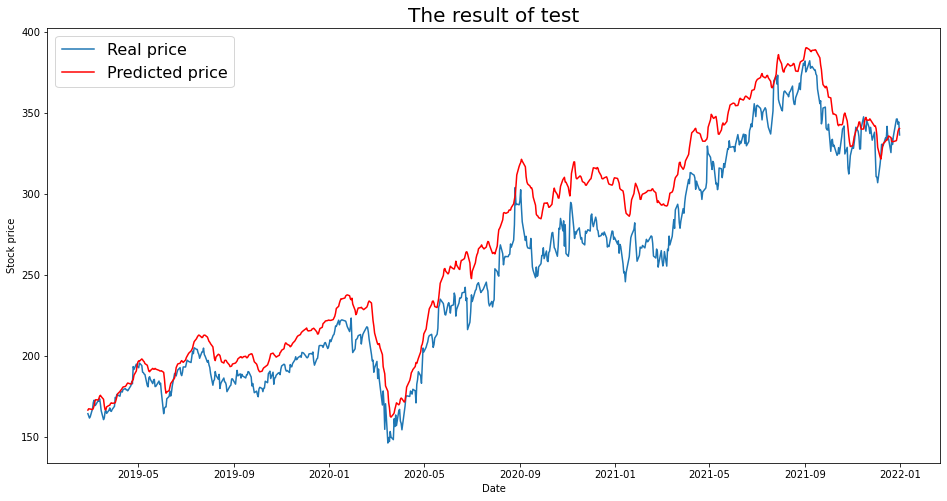

-- RMSE --  21.745486463616302


<Figure size 432x288 with 0 Axes>

In [16]:
path = r'Data\dataPreprocessed'

# Load index
test_predict_index = np.load(os.path.join(path,"index_test.npy"), allow_pickle=True)

# Load test dataset/ model
G_model = models.load_model(r'Models\trying\wgan_gp_0100epoch.h5')
X_test = np.load(os.path.join(path,"X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path,"y_test.npy"), allow_pickle=True)

get_test_plot(X_test, y_test, G_model, y_scaler_function, test_predict_index)